<a href="https://colab.research.google.com/github/tas0931/Music_Clustering_CSE425/blob/main/code%20(src)/easy_tasks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Cell 2: Install required libraries
!pip install librosa
!pip install umap-learn
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install torch torchvision

In [3]:
# Cell 3: Import all necessary libraries
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import umap
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

All libraries imported successfully!
PyTorch version: 2.9.0+cpu
CUDA available: False


In [4]:
# Cell 4: Define dataset path and explore structure
dataset_path = '/content/drive/MyDrive/cse425 datasets/FMA_Dataset'

# Check if path exists
if os.path.exists(dataset_path):
    print(f" Dataset path found: {dataset_path}")
    print("\nDirectory structure:")
    for item in os.listdir(dataset_path):
        item_path = os.path.join(dataset_path, item)
        print(f"  - {item} ({'Directory' if os.path.isdir(item_path) else 'File'})")
else:
    print(f"✗ Dataset path not found: {dataset_path}")
    print("Please check the path!")

 Dataset path found: /content/drive/MyDrive/cse425 datasets/FMA_Dataset

Directory structure:
  - fma_metadata (Directory)
  - fma_small (Directory)


In [5]:
# Cell 5: Locate audio files in folders 050-100
audio_base_path = os.path.join(dataset_path, 'fma_small')

# Get all audio files from folders 050 to 96
audio_files = []
folder_range = range(50, 97)

print("Scanning folders 050 to 96...")
for folder_num in tqdm(folder_range):
    folder_name = f"{folder_num:03d}"  # Format as 050, 051, etc.
    folder_path = os.path.join(audio_base_path, folder_name)

    if os.path.exists(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith('.mp3'):
                audio_files.append(os.path.join(folder_path, file))

print(f"\n Total audio files found: {len(audio_files)}")
print(f"Sample files:")
for i in range(min(5, len(audio_files))):
    print(f"  {i+1}. {audio_files[i]}")

Scanning folders 050 to 96...


100%|██████████| 47/47 [00:14<00:00,  3.18it/s]


 Total audio files found: 2294
Sample files:
  1. /content/drive/MyDrive/cse425 datasets/FMA_Dataset/fma_small/050/050283.mp3
  2. /content/drive/MyDrive/cse425 datasets/FMA_Dataset/fma_small/050/050449.mp3
  3. /content/drive/MyDrive/cse425 datasets/FMA_Dataset/fma_small/050/050444.mp3
  4. /content/drive/MyDrive/cse425 datasets/FMA_Dataset/fma_small/050/050754.mp3
  5. /content/drive/MyDrive/cse425 datasets/FMA_Dataset/fma_small/050/050836.mp3


In [6]:
# Cell 6: Define feature extraction function
def extract_audio_features(audio_path, sr=22050, n_mfcc=20, duration=30):
    """
    Extract MFCC features from audio file

    Parameters:
    - audio_path: path to audio file
    - sr: sampling rate
    - n_mfcc: number of MFCC coefficients
    - duration: duration to load (seconds)

    Returns:
    - feature vector (flattened MFCCs)
    """
    try:
        # Load audio file
        y, sr = librosa.load(audio_path, sr=sr, duration=duration)

        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

        # Compute statistics over time (mean and std)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)

        # Concatenate features
        features = np.concatenate([mfcc_mean, mfcc_std])

        return features

    except Exception as e:
        print(f"Error processing {audio_path}: {str(e)}")
        return None

# Test feature extraction on one file
print("Testing feature extraction...")
test_features = extract_audio_features(audio_files[0])
print(f"Feature shape: {test_features.shape}")
print(f"Feature vector length: {len(test_features)}")

Testing feature extraction...
Feature shape: (40,)
Feature vector length: 40


In [7]:
# Cell 7: Extract features from all audio files
print("Extracting features from all audio files...")
print("This may take several minutes...\n")

all_features = []
valid_files = []

for audio_file in tqdm(audio_files, desc="Processing audio files"):
    features = extract_audio_features(audio_file)
    if features is not None:
        all_features.append(features)
        valid_files.append(audio_file)

# Convert to numpy array
X = np.array(all_features)

print(f"\n✓ Feature extraction complete!")
print(f"Final dataset shape: {X.shape}")
print(f"Number of samples: {X.shape[0]}")
print(f"Feature dimension: {X.shape[1]}")

Extracting features from all audio files...
This may take several minutes...



Processing audio files: 100%|██████████| 2294/2294 [23:35<00:00,  1.62it/s]


✓ Feature extraction complete!
Final dataset shape: (2294, 40)
Number of samples: 2294
Feature dimension: 40


In [8]:
# Cell 8: Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(" Features normalized")
print(f"Mean: {X_scaled.mean():.6f}")
print(f"Std: {X_scaled.std():.6f}")

 Features normalized
Mean: -0.000000
Std: 1.000000


In [9]:
# Cell 9: Define VAE Architecture
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, latent_dim=32):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)

        # Latent space
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, input_dim)

        self.latent_dim = latent_dim

    def encode(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        h = F.relu(self.fc4(h))
        return self.fc5(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# Define loss function
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    """
    VAE loss = Reconstruction loss + KL divergence
    """
    # Reconstruction loss (MSE)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')

    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + beta * kl_loss

print(" VAE architecture defined")

 VAE architecture defined


In [10]:
# Cell 10: Create PyTorch Dataset and DataLoader
class MusicDataset(Dataset):
    def __init__(self, features):
        self.features = torch.FloatTensor(features)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx]

# Create dataset and dataloader
dataset = MusicDataset(X_scaled)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f" Dataset created")
print(f"Number of batches: {len(dataloader)}")

 Dataset created
Number of batches: 72


In [11]:
# Cell 11: Initialize and train VAE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}\n")

# Initialize model
input_dim = X_scaled.shape[1]
latent_dim = 32
vae = VAE(input_dim=input_dim, hidden_dim=256, latent_dim=latent_dim).to(device)

# Optimizer
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Training parameters
num_epochs = 100
train_losses = []

print("Training VAE...")
print("=" * 50)

for epoch in range(num_epochs):
    vae.train()
    epoch_loss = 0

    for batch_idx, data in enumerate(dataloader):
        data = data.to(device)

        # Forward pass
        recon_batch, mu, logvar = vae(data)
        loss = vae_loss(recon_batch, data, mu, logvar)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataset)
    train_losses.append(avg_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("\n Training complete!")

Using device: cpu

Training VAE...
Epoch [10/100], Loss: 22.4623
Epoch [20/100], Loss: 21.3538
Epoch [30/100], Loss: 20.7570
Epoch [40/100], Loss: 20.2519
Epoch [50/100], Loss: 20.1059
Epoch [60/100], Loss: 19.9091
Epoch [70/100], Loss: 19.7872
Epoch [80/100], Loss: 19.5508
Epoch [90/100], Loss: 19.4293
Epoch [100/100], Loss: 19.3511

 Training complete!


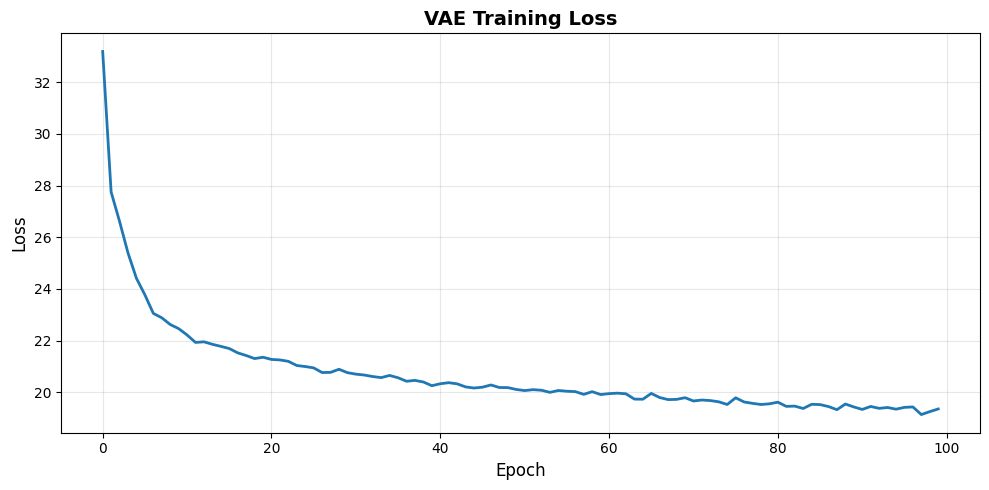

In [12]:
# Cell 12: Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, linewidth=2)
plt.title('VAE Training Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [13]:
# Cell 13: Extract latent features from trained VAE
vae.eval()

latent_features = []
with torch.no_grad():
    for data in dataloader:
        data = data.to(device)
        mu, _ = vae.encode(data)
        latent_features.append(mu.cpu().numpy())

# Concatenate all batches
Z_vae = np.vstack(latent_features)

print(f"Latent representations extracted")
print(f"Latent feature shape: {Z_vae.shape}")
print(f"Number of samples: {Z_vae.shape[0]}")
print(f"Latent dimension: {Z_vae.shape[1]}")

Latent representations extracted
Latent feature shape: (2294, 32)
Number of samples: 2294
Latent dimension: 32


In [14]:
# Cell 14: K-Means clustering on VAE latent features
# Determine optimal number of clusters (we'll try a range)
n_clusters = 10  # You can adjust this

kmeans_vae = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters_vae = kmeans_vae.fit_predict(Z_vae)

# Calculate metrics
silhouette_vae = silhouette_score(Z_vae, clusters_vae)
calinski_vae = calinski_harabasz_score(Z_vae, clusters_vae)

print("VAE + K-Means Results:")
print("=" * 50)
print(f"Number of clusters: {n_clusters}")
print(f"Silhouette Score: {silhouette_vae:.4f}")
print(f"Calinski-Harabasz Index: {calinski_vae:.4f}")
print("\nCluster distribution:")
unique, counts = np.unique(clusters_vae, return_counts=True)
for cluster_id, count in zip(unique, counts):
    print(f"  Cluster {cluster_id}: {count} samples ({count/len(clusters_vae)*100:.1f}%)")

VAE + K-Means Results:
Number of clusters: 10
Silhouette Score: 0.1048
Calinski-Harabasz Index: 183.8098

Cluster distribution:
  Cluster 0: 211 samples (9.2%)
  Cluster 1: 210 samples (9.2%)
  Cluster 2: 352 samples (15.3%)
  Cluster 3: 150 samples (6.5%)
  Cluster 4: 401 samples (17.5%)
  Cluster 5: 150 samples (6.5%)
  Cluster 6: 285 samples (12.4%)
  Cluster 7: 155 samples (6.8%)
  Cluster 8: 123 samples (5.4%)
  Cluster 9: 257 samples (11.2%)


In [15]:
# Cell 15: PCA + K-Means baseline
# Apply PCA to reduce to same latent dimension as VAE
pca = PCA(n_components=latent_dim)
Z_pca = pca.fit_transform(X_scaled)

print(f"PCA transformation complete")
print(f"PCA feature shape: {Z_pca.shape}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")

# K-Means clustering on PCA features
kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters_pca = kmeans_pca.fit_predict(Z_pca)

# Calculate metrics
silhouette_pca = silhouette_score(Z_pca, clusters_pca)
calinski_pca = calinski_harabasz_score(Z_pca, clusters_pca)

print("\nPCA + K-Means Results:")
print("=" * 50)
print(f"Number of clusters: {n_clusters}")
print(f"Silhouette Score: {silhouette_pca:.4f}")
print(f"Calinski-Harabasz Index: {calinski_pca:.4f}")
print("\nCluster distribution:")
unique, counts = np.unique(clusters_pca, return_counts=True)
for cluster_id, count in zip(unique, counts):
    print(f"  Cluster {cluster_id}: {count} samples ({count/len(clusters_pca)*100:.1f}%)")

PCA transformation complete
PCA feature shape: (2294, 32)
Explained variance ratio: 0.9694

PCA + K-Means Results:
Number of clusters: 10
Silhouette Score: 0.0772
Calinski-Harabasz Index: 202.4456

Cluster distribution:
  Cluster 0: 353 samples (15.4%)
  Cluster 1: 197 samples (8.6%)
  Cluster 2: 155 samples (6.8%)
  Cluster 3: 405 samples (17.7%)
  Cluster 4: 366 samples (16.0%)
  Cluster 5: 276 samples (12.0%)
  Cluster 6: 44 samples (1.9%)
  Cluster 7: 124 samples (5.4%)
  Cluster 8: 180 samples (7.8%)
  Cluster 9: 194 samples (8.5%)


In [16]:
# Cell 16: Compare VAE vs Baseline
results_df = pd.DataFrame({
    'Method': ['VAE + K-Means', 'PCA + K-Means'],
    'Silhouette Score': [silhouette_vae, silhouette_pca],
    'Calinski-Harabasz Index': [calinski_vae, calinski_pca]
})

print("\nComparison of Methods:")
print("=" * 60)
print(results_df.to_string(index=False))

# Determine which is better
print("\n" + "=" * 60)
if silhouette_vae > silhouette_pca:
    print(" VAE performs BETTER on Silhouette Score")
else:
    print(" PCA performs BETTER on Silhouette Score")

if calinski_vae > calinski_pca:
    print(" VAE performs BETTER on Calinski-Harabasz Index")
else:
    print(" PCA performs BETTER on Calinski-Harabasz Index")


Comparison of Methods:
       Method  Silhouette Score  Calinski-Harabasz Index
VAE + K-Means          0.104815               183.809769
PCA + K-Means          0.077223               202.445602

 VAE performs BETTER on Silhouette Score
 PCA performs BETTER on Calinski-Harabasz Index


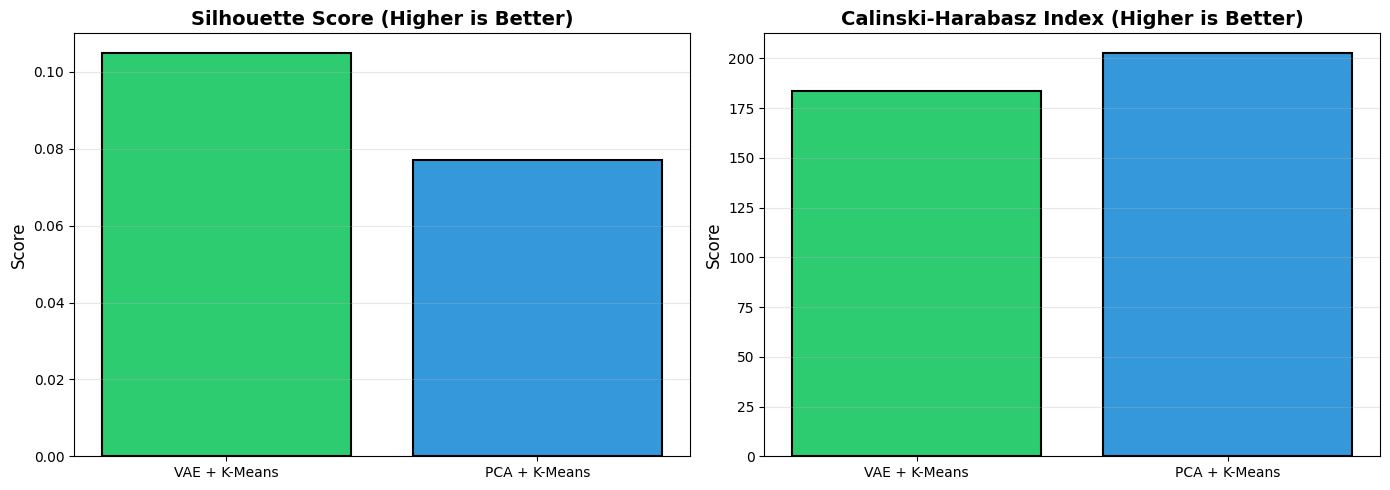

In [17]:
# Cell 17: Visualize comparison with bar plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Silhouette Score
axes[0].bar(['VAE + K-Means', 'PCA + K-Means'],
            [silhouette_vae, silhouette_pca],
            color=['#2ecc71', '#3498db'],
            edgecolor='black',
            linewidth=1.5)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Silhouette Score (Higher is Better)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Calinski-Harabasz Index
axes[1].bar(['VAE + K-Means', 'PCA + K-Means'],
            [calinski_vae, calinski_pca],
            color=['#2ecc71', '#3498db'],
            edgecolor='black',
            linewidth=1.5)
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('Calinski-Harabasz Index (Higher is Better)', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Computing t-SNE for VAE latent space...
 t-SNE computation complete


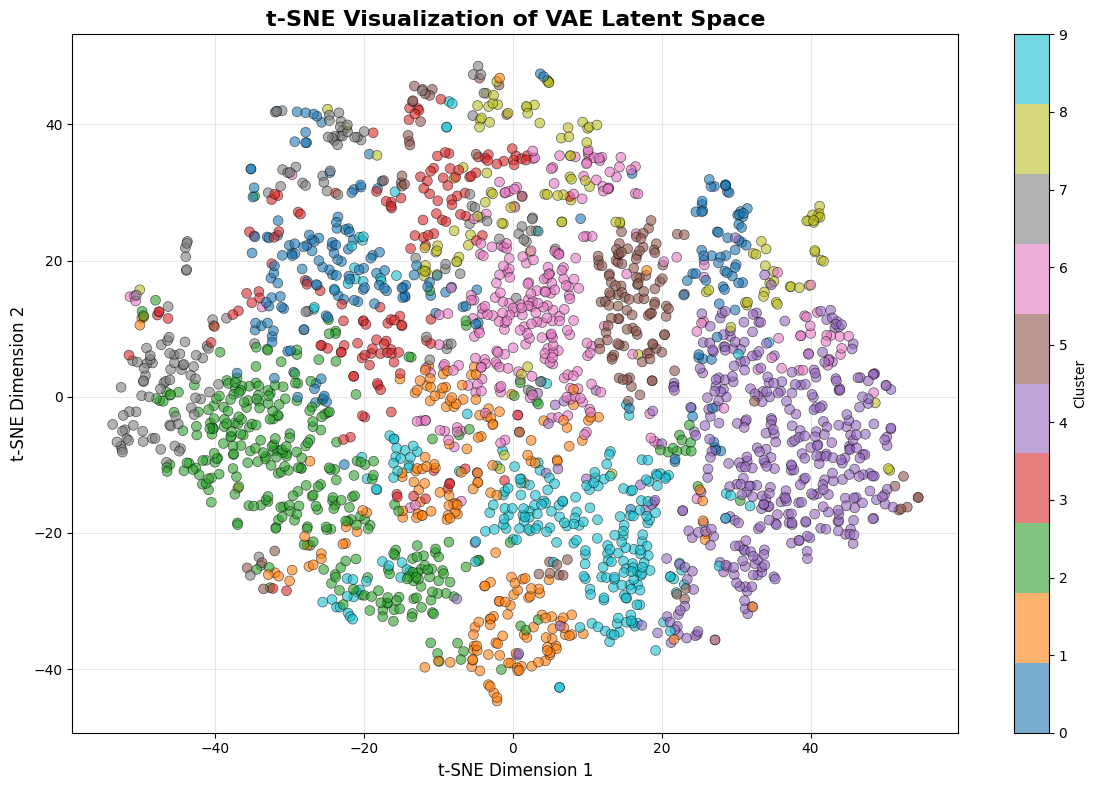

In [18]:
# Cell 18: t-SNE visualization for VAE
from sklearn.manifold import TSNE

print("Computing t-SNE for VAE latent space...")
tsne_vae = TSNE(n_components=2, random_state=42, perplexity=30)
Z_tsne_vae = tsne_vae.fit_transform(Z_vae)

print(" t-SNE computation complete")

# Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(Z_tsne_vae[:, 0], Z_tsne_vae[:, 1],
                     c=clusters_vae, cmap='tab10',
                     s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Cluster')
plt.title('t-SNE Visualization of VAE Latent Space', fontsize=16, fontweight='bold')
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Computing t-SNE for PCA space...
 t-SNE computation complete


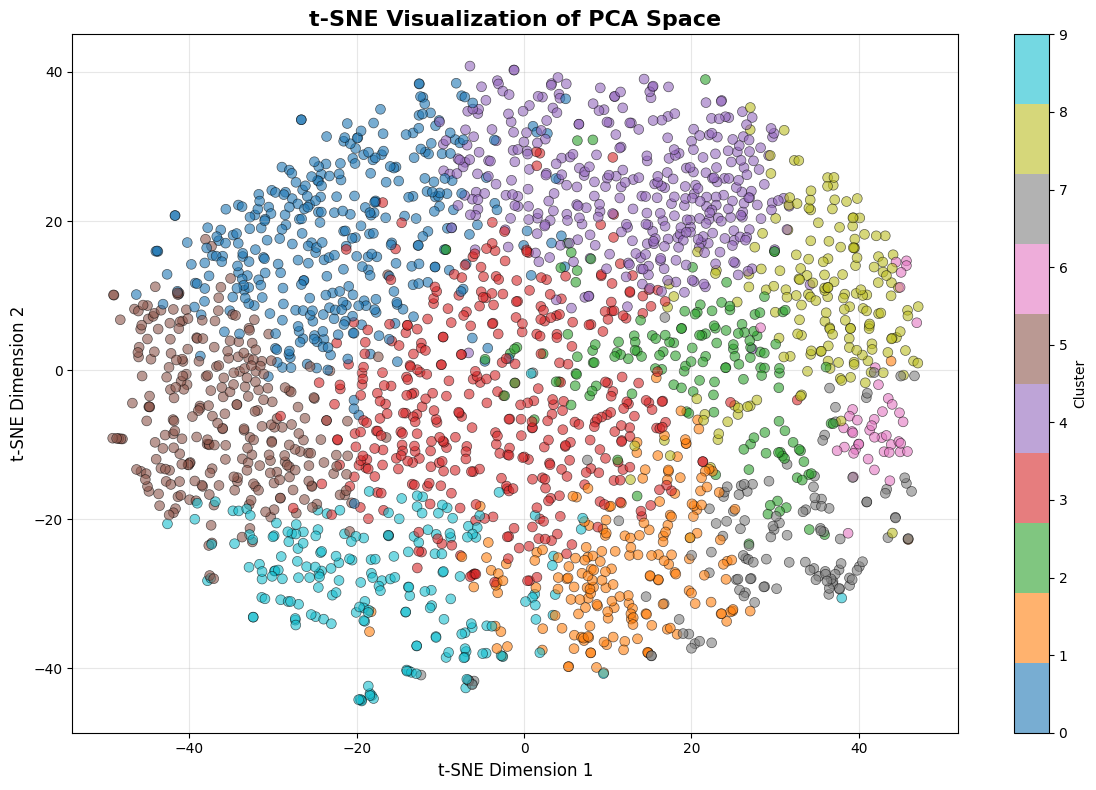

In [19]:
# Cell 19: t-SNE visualization for PCA
print("Computing t-SNE for PCA space...")
tsne_pca = TSNE(n_components=2, random_state=42, perplexity=30)
Z_tsne_pca = tsne_pca.fit_transform(Z_pca)

print(" t-SNE computation complete")

# Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(Z_tsne_pca[:, 0], Z_tsne_pca[:, 1],
                     c=clusters_pca, cmap='tab10',
                     s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Cluster')
plt.title('t-SNE Visualization of PCA Space', fontsize=16, fontweight='bold')
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Computing UMAP for VAE latent space...
UMAP computation complete


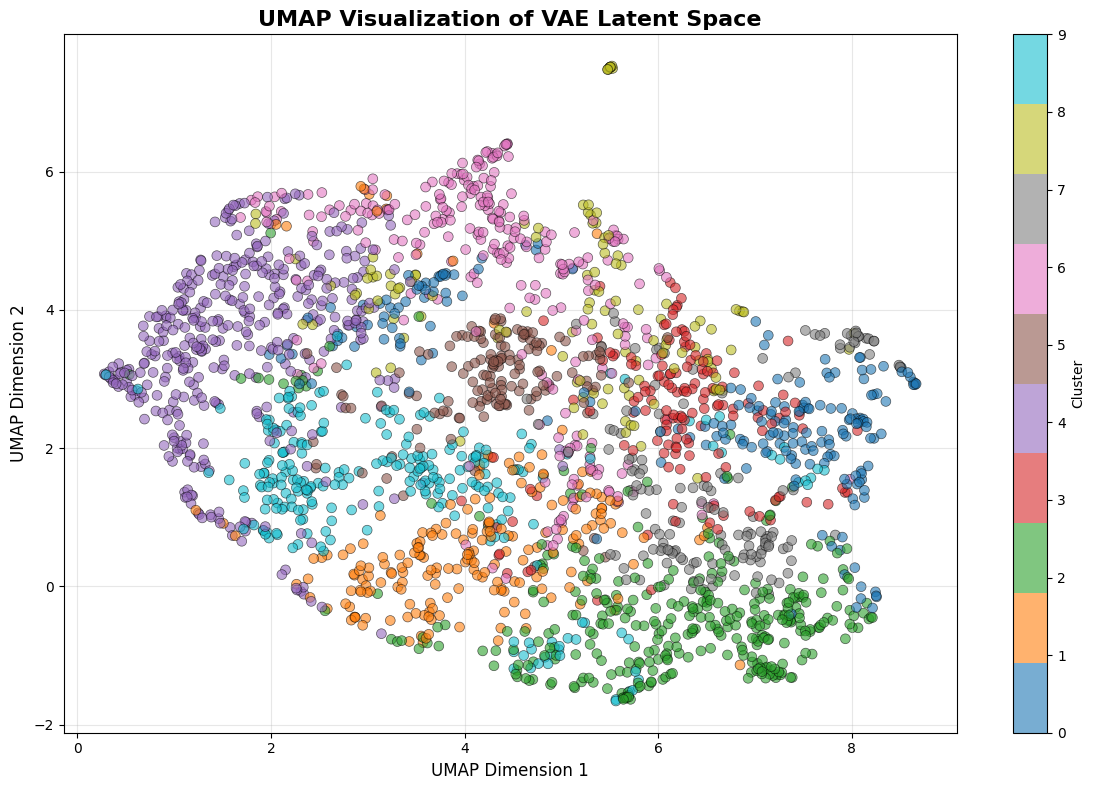

In [20]:
# Cell 20: UMAP visualization for VAE
print("Computing UMAP for VAE latent space...")
umap_vae = umap.UMAP(n_components=2, random_state=42)
Z_umap_vae = umap_vae.fit_transform(Z_vae)

print("UMAP computation complete")

# Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(Z_umap_vae[:, 0], Z_umap_vae[:, 1],
                     c=clusters_vae, cmap='tab10',
                     s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Cluster')
plt.title('UMAP Visualization of VAE Latent Space', fontsize=16, fontweight='bold')
plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Computing UMAP for PCA space...
 UMAP computation complete


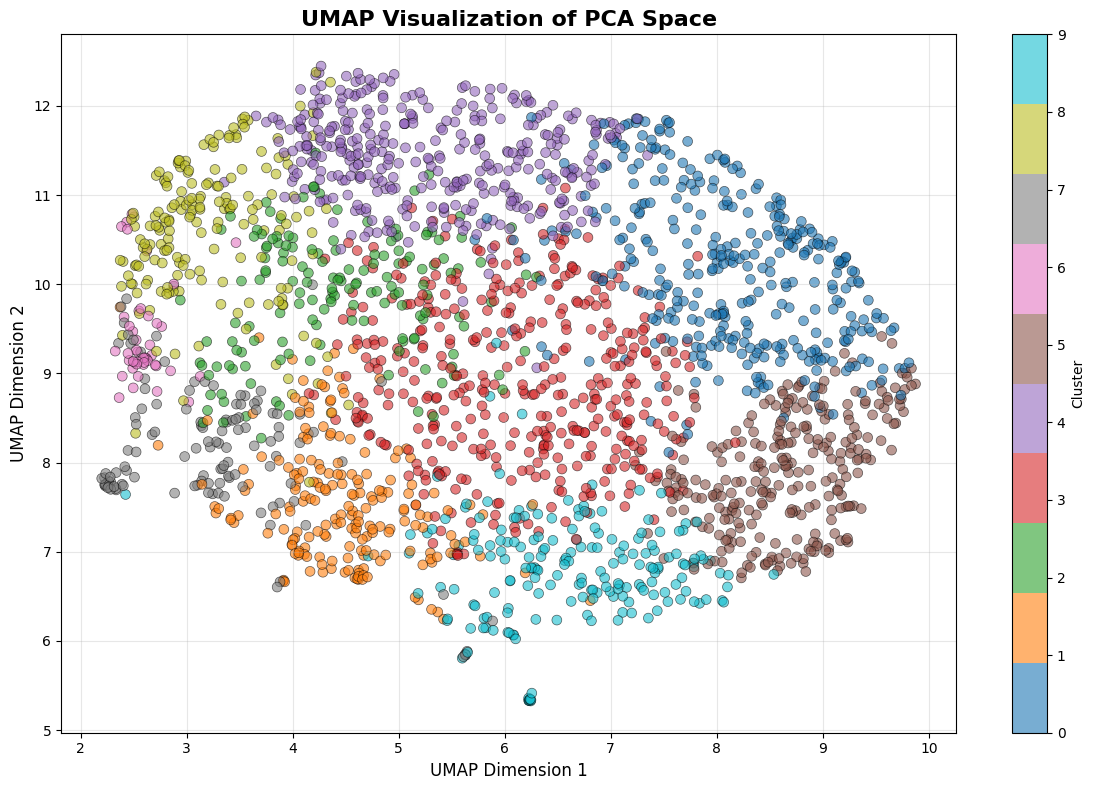

In [21]:
# Cell 21: UMAP visualization for PCA
print("Computing UMAP for PCA space...")
umap_pca = umap.UMAP(n_components=2, random_state=42)
Z_umap_pca = umap_pca.fit_transform(Z_pca)

print(" UMAP computation complete")

# Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(Z_umap_pca[:, 0], Z_umap_pca[:, 1],
                     c=clusters_pca, cmap='tab10',
                     s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Cluster')
plt.title('UMAP Visualization of PCA Space', fontsize=16, fontweight='bold')
plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

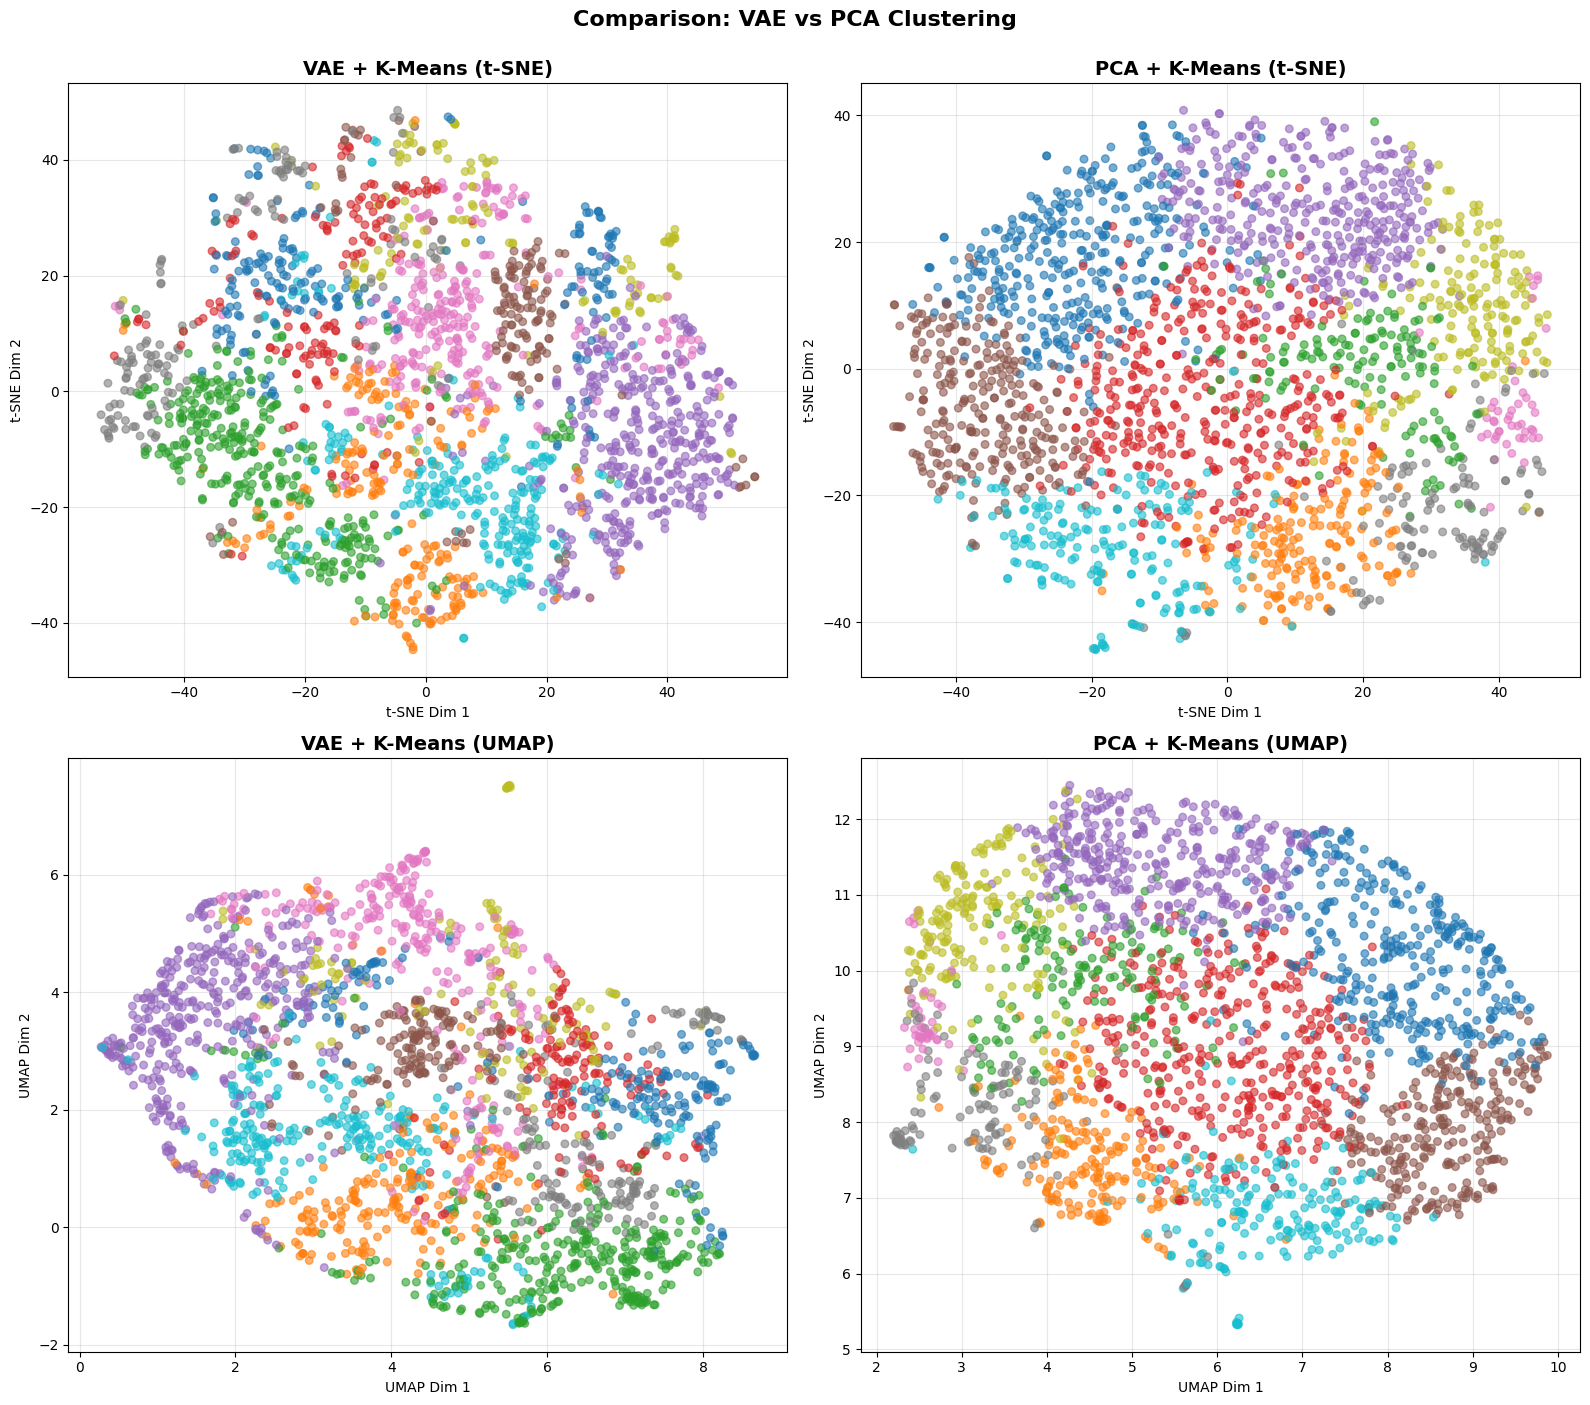

In [22]:
# Cell 22: Side-by-side comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# VAE t-SNE
axes[0, 0].scatter(Z_tsne_vae[:, 0], Z_tsne_vae[:, 1],
                   c=clusters_vae, cmap='tab10', s=30, alpha=0.6)
axes[0, 0].set_title('VAE + K-Means (t-SNE)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('t-SNE Dim 1')
axes[0, 0].set_ylabel('t-SNE Dim 2')
axes[0, 0].grid(True, alpha=0.3)

# PCA t-SNE
axes[0, 1].scatter(Z_tsne_pca[:, 0], Z_tsne_pca[:, 1],
                   c=clusters_pca, cmap='tab10', s=30, alpha=0.6)
axes[0, 1].set_title('PCA + K-Means (t-SNE)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('t-SNE Dim 1')
axes[0, 1].set_ylabel('t-SNE Dim 2')
axes[0, 1].grid(True, alpha=0.3)

# VAE UMAP
axes[1, 0].scatter(Z_umap_vae[:, 0], Z_umap_vae[:, 1],
                   c=clusters_vae, cmap='tab10', s=30, alpha=0.6)
axes[1, 0].set_title('VAE + K-Means (UMAP)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('UMAP Dim 1')
axes[1, 0].set_ylabel('UMAP Dim 2')
axes[1, 0].grid(True, alpha=0.3)

# PCA UMAP
axes[1, 1].scatter(Z_umap_pca[:, 0], Z_umap_pca[:, 1],
                   c=clusters_pca, cmap='tab10', s=30, alpha=0.6)
axes[1, 1].set_title('PCA + K-Means (UMAP)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('UMAP Dim 1')
axes[1, 1].set_ylabel('UMAP Dim 2')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Comparison: VAE vs PCA Clustering', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [23]:
# Cell 23: Save all results
import pickle

# Create results dictionary
results = {
    'X_scaled': X_scaled,
    'Z_vae': Z_vae,
    'Z_pca': Z_pca,
    'clusters_vae': clusters_vae,
    'clusters_pca': clusters_pca,
    'metrics': {
        'vae_silhouette': silhouette_vae,
        'vae_calinski': calinski_vae,
        'pca_silhouette': silhouette_pca,
        'pca_calinski': calinski_pca
    },
    'audio_files': valid_files,
    'n_clusters': n_clusters,
    'latent_dim': latent_dim
}

# Save to Google Drive
save_path = '/content/drive/MyDrive/cse425 datasets/vae_clustering_results.pkl'
with open(save_path, 'wb') as f:
    pickle.dump(results, f)

print(f" Results saved to: {save_path}")

# Save metrics as CSV
results_df.to_csv('/content/drive/MyDrive/cse425 datasets/clustering_metrics.csv', index=False)
print(" Metrics saved to CSV")

# Save model
torch.save(vae.state_dict(), '/content/drive/MyDrive/cse425 datasets/vae_model.pth')
print(" VAE model saved")

 Results saved to: /content/drive/MyDrive/cse425 datasets/vae_clustering_results.pkl
 Metrics saved to CSV
 VAE model saved


In [24]:
# Cell 24: Generate comprehensive summary
print("=" * 70)
print("EASY TASK - VAE MUSIC CLUSTERING - FINAL REPORT")
print("=" * 70)
print()
print("DATASET INFORMATION:")
print("-" * 70)
print(f"Total audio files processed: {len(valid_files)}")
print(f"Audio folders used: 050 to 150")
print(f"Original feature dimension: {X.shape[1]}")
print(f"Latent dimension: {latent_dim}")
print()
print("VAE ARCHITECTURE:")
print("-" * 70)
print(f"Input dimension: {input_dim}")
print(f"Hidden dimension: 256")
print(f"Latent dimension: {latent_dim}")
print(f"Training epochs: {num_epochs}")
print(f"Final loss: {train_losses[-1]:.4f}")
print()
print("CLUSTERING RESULTS:")
print("-" * 70)
print(f"Number of clusters: {n_clusters}")
print()
print("VAE + K-Means:")
print(f"  Silhouette Score: {silhouette_vae:.4f} (Higher is better)")
print(f"  Calinski-Harabasz Index: {calinski_vae:.4f} (Higher is better)")
print()
print("PCA + K-Means (Baseline):")
print(f"  Silhouette Score: {silhouette_pca:.4f}")
print(f"  Calinski-Harabasz Index: {calinski_pca:.4f}")
print()
print("COMPARISON:")
print("-" * 70)
improvement_silhouette = ((silhouette_vae - silhouette_pca) / abs(silhouette_pca)) * 100
improvement_calinski = ((calinski_vae - calinski_pca) / calinski_pca) * 100

print(f"Silhouette Score improvement: {improvement_silhouette:+.2f}%")
print(f"Calinski-Harabasz improvement: {improvement_calinski:+.2f}%")
print()
if silhouette_vae > silhouette_pca and calinski_vae > calinski_pca:
    print("VAE outperforms PCA on BOTH metrics!")
elif silhouette_vae > silhouette_pca or calinski_vae > calinski_pca:
    print("VAE outperforms PCA on at least one metric")
else:
    print("PCA baseline performs better (may need hyperparameter tuning)")
print()
print("=" * 70)
print(" EASY TASK COMPLETED SUCCESSFULLY!")
print("=" * 70)

EASY TASK - VAE MUSIC CLUSTERING - FINAL REPORT

DATASET INFORMATION:
----------------------------------------------------------------------
Total audio files processed: 2294
Audio folders used: 050 to 150
Original feature dimension: 40
Latent dimension: 32

VAE ARCHITECTURE:
----------------------------------------------------------------------
Input dimension: 40
Hidden dimension: 256
Latent dimension: 32
Training epochs: 100
Final loss: 19.3511

CLUSTERING RESULTS:
----------------------------------------------------------------------
Number of clusters: 10

VAE + K-Means:
  Silhouette Score: 0.1048 (Higher is better)
  Calinski-Harabasz Index: 183.8098 (Higher is better)

PCA + K-Means (Baseline):
  Silhouette Score: 0.0772
  Calinski-Harabasz Index: 202.4456

COMPARISON:
----------------------------------------------------------------------
Silhouette Score improvement: +35.73%
Calinski-Harabasz improvement: -9.21%

VAE outperforms PCA on at least one metric

 EASY TASK COMPLETED 